# Heading 1

A short introduction or overview.

## Heading 2

- First bullet
- Second bullet

### Setup the harmonic system

We generate the data needed based on given paramters

In [47]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


In [48]:
def generate_data(periods=6, dt=0.1, omega=1.0, Q_scale=0.005, R_val=0.5, seed=42):
    """
    Generates:
      - x_true: shape (time_steps, 2), the "true" states of the system
                with process noise added at each step
      - A:      2x2 matrix = expm(A_euler)
      - Q:      2x2 process noise covariance
      - R_val:  scalar measurement noise variance
      - measurement_noises: shape (time_steps,), one noise sample per step

    The idea is to keep the same x_true and measurement_noises for
    both fixed and adaptive filters, so they see the *exact same* random draws.
    """
    np.random.seed(seed)  # reproducible
    
    # 1) Define system matrix A
    A_euler = np.array([[0, dt],
                        [-omega**2 * dt, 0]])
    A = scipy.linalg.expm(A_euler)  # discrete-time transition
    Q = np.eye(2) * Q_scale * dt    # process noise covariance
    
    # 2) Number of time steps
    time_steps = round(periods * 2 * np.pi / dt)
    t_array = np.linspace(0, periods*2*np.pi, time_steps)

    
    # 3) Generate "true" states with process noise
    x_true = np.zeros((time_steps, 2))
    x_true[0] = [1.0, 0.0]  # initial condition
    for k in range(time_steps - 1):
        w_k = np.random.multivariate_normal([0, 0], Q)
        x_true[k+1] = A @ x_true[k] + w_k
    
    # 4) Generate measurement noises (one per step)
    #    We'll reuse these for *both* filters.
    measurement_noises = np.random.normal(0, np.sqrt(R_val), size=time_steps)
    
    return t_array, x_true, A, Q, R_val, measurement_noises, dt


### Helper functions to do kalman update, predict and compute the best measurement vector

In [49]:

def kalman_predict(x_est, P_est, A, Q):
    x_pred = A @ x_est
    P_pred = A @ P_est @ A.T + Q
    return x_pred, P_pred

def kalman_update(x_pred, P_pred, y, m, R):
    y_pred = m @ x_pred
    innovation = y - y_pred
    S = m @ P_pred @ m + R  # scalar
    K = (P_pred @ m) / S    # shape (2,)
    x_est = x_pred + K * innovation
    P_est = P_pred - np.outer(K, m) @ P_pred
    return x_est, P_est

def principal_eigenvector(P):
    vals, vecs = np.linalg.eig(P)
    idx = np.argmax(vals)
    v = vecs[:, idx]
    return v / np.linalg.norm(v)


### The fixed and adaptive kalman filters

In [50]:
def run_kalman_fixed(x_true, A, Q, R_val, measurement_noises):
    """
    Uses m = [1, 0] at each step, reusing the same measurement_noises
    so that measurement_noises[k] is the random part of y_k.
    """
    time_steps = x_true.shape[0]
    x_est = np.array([0.0, 0.0])
    P_est = np.eye(2) * 1.0
    
    x_est_array = np.zeros((time_steps, 2))
    measurements = np.zeros(time_steps)
    
    for k in range(time_steps):
        # Predict
        x_pred, P_pred = kalman_predict(x_est, P_est, A, Q)
        
        # True state at step k
        xk_true = x_true[k]
        
        # Generate measurement: same noise draw, but direction = [1,0]
        m = np.array([1.0, 0.0])
        # print(f"fixed m: {m}")
        y = m @ xk_true + measurement_noises[k]
        
        # Update
        x_est, P_est = kalman_update(x_pred, P_pred, y, m, R_val)
        
        x_est_array[k] = x_est
        measurements[k] = y
    
    return x_est_array, measurements

In [51]:

def run_kalman_adaptive(x_true, A, Q, R_val, measurement_noises):
    """
    Uses m = principal_eigenvector(P_pred) each step, reusing the same
    measurement_noises.  So measurement_noises[k] is the random part of y_k.
    """
    time_steps = x_true.shape[0]
    x_est = np.array([0.0, 0.0])
    P_est = np.eye(2) * 1.0
    
    x_est_array = np.zeros((time_steps, 2))
    measurements = np.zeros(time_steps)
    
    for k in range(time_steps):
        # Predict
        x_pred, P_pred = kalman_predict(x_est, P_est, A, Q)
        
        # True state at step k
        xk_true = x_true[k]
        
        # Adaptive measurement direction
        m = principal_eigenvector(P_pred)
        # print(f"adaptive m: {m}")
        
        # Generate measurement using the *same* noise draw as the fixed approach
        y = m @ xk_true + measurement_noises[k]
        
        # Update
        x_est, P_est = kalman_update(x_pred, P_pred, y, m, R_val)
        
        x_est_array[k] = x_est
        measurements[k] = y
    
    return x_est_array, measurements

In [52]:
t_array, x_true, A, Q, R_val, measurement_noises, dt = generate_data(
    periods=10, dt=0.1, omega=1.0, 
    Q_scale=0.05, R_val=0.5, seed=42
    )

time_steps = x_true.shape[0]
    
# 2) Run Kalman with fixed measurement
x_est_fixed, meas_fixed = run_kalman_fixed(x_true, A, Q, R_val, measurement_noises)
    
# 3) Run Kalman with adaptive measurement
x_est_adaptive, meas_adaptive = run_kalman_adaptive(x_true, A, Q, R_val, measurement_noises)



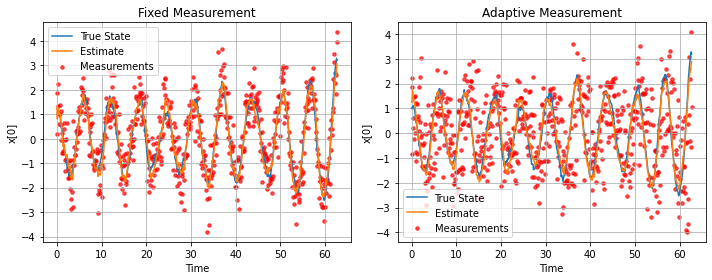

In [53]:
plt.figure(figsize=(10,4))
    
# Left: Fixed
plt.subplot(1,2,1)
plt.plot(time_array, x_true[:,0], label="True State")
plt.plot(time_array, x_est_fixed[:,0], label="Estimate")
plt.scatter(time_array, meas_fixed, s=12, color='r', alpha=0.7, label="Measurements")
plt.title("Fixed Measurement")
plt.xlabel("Time")
plt.ylabel("x[0]")
plt.grid(True)
plt.legend()

# Right: Adaptive
plt.subplot(1,2,2)
plt.plot(time_array, x_true[:,0], label="True State")
plt.plot(time_array, x_est_adaptive[:,0], label="Estimate")
plt.scatter(time_array, meas_adaptive, s=12, color='r', alpha=0.7, label="Measurements")
plt.title("Adaptive Measurement")
plt.xlabel("Time")
plt.ylabel("x[0]")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Now doing the same for Lorenz

In [54]:


sigma = 10.0
rho = 28.0
beta = 8/3
dt = 0.02
t_end = 20.0
x0 = [1.0, 1.0, 1.0]
R = np.eye(2) * 0.2
Q = np.eye(3)
seed = 42

def lorenz_system(t, state):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

In [55]:

def generate_lorenz_data():
    """
    Generates a Lorenz trajectory by numerically integrating the ODE,
    then adds measurement noise for observations of (x, y).

    :param sigma, rho, beta: Lorenz system parameters.
    :param dt: time step for the solver output.
    :param t_end: end time.
    :param x0: initial condition [x, y, z].
    :param R_val: measurement noise variance for each of x, y.
    :param seed: random seed for reproducibility.

    :return:
      time_span: array of time points of length N.
      true_states: shape (N, 3), the solution of the Lorenz system [x, y, z].
      measurements: shape (N, 2), noisy measurements of [x, y].
    """



    np.random.seed(seed)

    # Build the time array and solve the ODE
    N = round(t_end / dt)
    time_span = np.linspace(0, t_end, N)
    sol = solve_ivp(lorenz_system, [time_span[0], time_span[-1]], x0, t_eval=time_span)

    # True states: shape (N, 3) after transposing sol.y (which is (3, N))
    true_states = sol.y.T

    H = np.array([[1, 0, 0], [0, 1, 0]])

    #inital state and covariance
    x_est = np.array([1,1,1])
    P = np.eye(3) * 1.0

    # Generate measurement noise. We draw N samples from N(0, R).
    # shape: (N,2). Then we multiply by sqrtm(R).T for correlated if needed.
    noise = np.random.normal(0, 1, (N, 2)) @ scipy.linalg.sqrtm(R).T

    #so we take (x, y) from the true states and add noise


    measurements = true_states[:, :2] + noise

    return time_span, true_states, measurements


## helper functions

In [56]:
def lorenz_jacobian(x_est, sigma=10, rho=28, beta=8/3):
    """Compute the Jacobian matrix for the Lorenz system at state x"""
    # Extract state variables as float values
    x1 = x_est[0]
    x2 = x_est[1]
    x3 = x_est[2]
    
    # Construct Jacobian with proper float dtype
    J = np.array([
        [-sigma, sigma, 0], 
        [rho - x3, -1, -x1],
        [x2, x1, -beta]
    ], dtype=float)
    
    return J


def kalman_update_lorenz(x, P, y, m, R):
    """
    Perform the Kalman update step with adaptive measurement direction.
    
    Args:
        x: State estimate (3x1 vector)
        P: State covariance matrix (3x3 matrix)
        y: Scalar measurement value
        sigma2: Measurement noise variance (scalar)
    
    Returns:
        x_new: Updated state estimate
        P_new: Updated state covariance matrix
    """

    m = m.reshape(-1, 1)
    x = x.reshape(-1, 1)

    # Compute predicted measurement (scalar)
    y_pred = m.T @ x
    
    # Compute innovation (difference between observed and predicted measurement)
    innovation = y - y_pred
    
    # Innovation variance (scalar)
    S = (m.T @ (P @ m)) + R
    
    # Kalman Gain (vector)
    if np.isscalar(S):
        K = (P @ m) / S
    else:
        K = (P @ m) @ np.linalg.inv(S)
    
    # Update state estimate
    x_new = x + K * innovation
    
    # Update covariance matrix using outer product
    P_new = P - np.outer(K.flatten(), (m.T @ P).flatten())
        
    return x_new.flatten(), P_new

def kalman_predict_lorenz(x_est, P_est, A, Q, dt):

    f = lorenz_system(0, x_est)
    J = lorenz_jacobian(x_est)
    A = scipy.linalg.expm(J*dt)

    x_pred = A @ x_est
    P_pred = A @ P_est @ A.T + Q
    return x_pred, P_pred

### main function

In [57]:

def iterate_kalman_lorenz(x_true, A, Q, R_val, measurement_noises, Fixed, dt = 0.02):

    time_steps = x_true.shape[0]
    x_est = np.array([0.0, 0.0, 0.0])
    P_est = np.eye(3) * 1.0

    x_est_array = np.zeros((time_steps, 3))
    measurements = np.zeros(time_steps)
    information_gains = np.zeros(time_steps)
    EntropyRate = np.zeros(time_steps)


    if Fixed:
        m_fixed = np.array([1.0, 0.0, 0.0])
        for k in range(time_steps):            

            # Predict
            jacobian = lorenz_jacobian(x_est)

            A = scipy.linalg.expm(jacobian*dt)
            x_pred, P_pred = kalman_predict_lorenz(x_est, P_est, A, Q, dt)


            # True state at step k
            xk_true = x_true[k]

            # Generate measurement: same noise draw, but direction = [1,0]

            y = m_fixed @ xk_true + measurement_noises[k]


            #Get variables for c)
            pre_det = np.linalg.det(P_pred)
            diff_entropy = np.log(np.sqrt(2*np.pi*np.e*np.linalg.det(Q)))


            # Update
            x_est, P_est = kalman_update_lorenz(x_pred, P_pred, y, m_fixed, R_val)


            post_det = np.linalg.det(P_est)
            J_eigen = np.linalg.eigvals(jacobian)
            J_sum = sum(max(0, eigenval.real) for eigenval in J_eigen)
            
            
            EntropyRate[k] = diff_entropy + np.log(np.abs(np.linalg.det(jacobian)) + 1e-10)            
            #information gain
            SignalNoise = (m_fixed.T @ P_pred @ m_fixed) / R_val
            information_gains[k] = 1/2*np.log(1 + SignalNoise)

            #store results
            x_est_array[k] = x_est
            measurements[k] = y
    
    else:
        for k in range(time_steps):
            # Predict
            jacobian = lorenz_jacobian(x_est)
            A = scipy.linalg.expm(jacobian*dt)
            x_pred, P_pred = kalman_predict_lorenz(x_est, P_est, A, Q, dt)

            # True state at step k
            xk_true = x_true[k]

            # Adaptive measurement direction
            
            m = principal_eigenvector(P_pred)

            # Generate measurement using the *same* noise draw as the fixed approach
            y = m @ xk_true + measurement_noises[k]

            #Get variables for c)
            pre_det = np.linalg.det(P_pred)
            diff_entropy = np.log(np.sqrt(2*np.pi*np.e*np.linalg.det(Q)))


            # Update
            x_est, P_est = kalman_update_lorenz(x_pred, P_pred, y, m, R_val)


            post_det = np.linalg.det(P_est)
            J_eigen = np.linalg.eigvals(jacobian)
            J_sum = sum(max(0, eigenval.real) for eigenval in J_eigen)
            EntropyRate[k] = diff_entropy + np.log(np.abs(np.linalg.det(jacobian)) + 1e-10)   
                     
            #information gain
            SignalNoise = (m.T @ P_pred @ m) / R_val
            information_gains[k] = 1/2*np.log(1 + SignalNoise)

            #store results
            x_est_array[k] = x_est
            measurements[k] = y

    return x_est_array, measurements, information_gains, EntropyRate
    

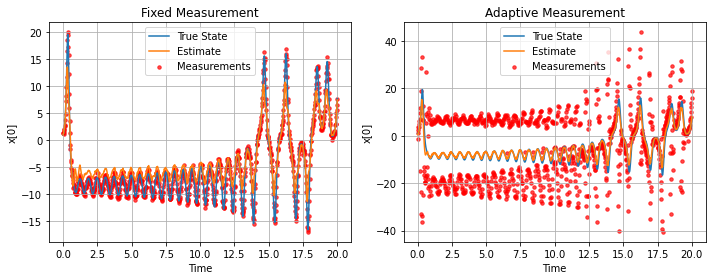

In [58]:
#get start values
t_array, x_true, Y_meas = generate_lorenz_data()
A = np.eye(3)
Q = np.eye(3) * 0.01
R_val = 0.2
measurement_noises = Y_meas[:,0] - x_true[:,0]


# Run the Kalman filter
states1, measurements1, infogains1, EntropyRate1 = iterate_kalman_lorenz(x_true, A, Q, R_val, measurement_noises, Fixed=True, dt=0.02)
states2, measurements2, infogains2, EntropyRate2 = iterate_kalman_lorenz(x_true, A, Q, R_val, measurement_noises, Fixed=False, dt=0.02)



# Plot the results from fixed and adaptive Kalman filters
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(t_array, x_true[:,0], label="True State")
plt.plot(t_array, states1[:,0], label="Estimate")
plt.scatter(t_array, measurements1, s=12, color='r', alpha=0.7, label="Measurements")
plt.title("Fixed Measurement")
plt.xlabel("Time")
plt.ylabel("x[0]")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(t_array, x_true[:,0], label="True State")
plt.plot(t_array, states2[:,0], label="Estimate")
plt.scatter(t_array, measurements2, s=12, color='r', alpha=0.7, label="Measurements")
plt.title("Adaptive Measurement")
plt.xlabel("Time")
plt.ylabel("x[0]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [59]:
#c) Calculate the entropy rate of the proxess.

# Make first the differential entropy in the process noise distribution.

#then calculate the log determinant of the jacobi matrix from each step. We take a average over that.
Avarage_information_gain1 = np.mean(infogains1)
Avarage_information_gain2 = np.mean(infogains2)

EntropyRate1 = np.mean(EntropyRate1)
EntropyRate2 = np.mean(EntropyRate2)

print(f"Average information gain for fixed measurement: {Avarage_information_gain1}")
print(f"Average information gain for adaptive measurement: {Avarage_information_gain2}")

print(f"Entropy rate for measurement: {EntropyRate1}")
print(f"Entropy rate for adaptive measurement: {EntropyRate2}")

Average information gain for fixed measurement: 0.17053654501524992
Average information gain for adaptive measurement: 0.19594475792235613
Entropy rate for measurement: -0.021705166564983308
Entropy rate for adaptive measurement: 0.667243560155752


## Now going over to using a constrained set of measurement vectors

In [60]:

def s(m):
    return sum(abs(x) for x in m)


def select_measurement_direction_from_M(P, OnlyBasis):
    """
    Given a covariance matrix P and a set of candidate unit vectors M,
    choose the m in M that maximizes m^T P m (i.e. gives the largest expected information gain).
    """

    # Define a set M of candidate unit vectors in R^n.
    # For a 3D system, you might include the basis vectors and some linear combinations.
    # For a 2D system, you might include [1, 0], [0, 1], [1, 1], etc.



    if P.shape[1] == 2:
        M = np.array([
            [1, 0],
            [0, 1],
            [1, 1],
            [1, -1],
            [-1, 1],
            [-1, -1],
        ])
        if OnlyBasis:
            M = np.array([
                [1, 0],
                [0, 1],
            ])
    else:

        M = np.array([
            [1, 0, 0],
            [0, 1, 0],
            [0, 0, 1],
            [1, 1, 0],
            [1, 0, 1],
            [0, 1, 1],
            [1, 1, 1],
            [-1, 1, 1],
            [1, -1, 1],
            [1, 1, -1],
            [-1, -1, 1],
            [-1, 1, -1],
            [1, -1, -1],
            [-1, -1, -1],
            [-1, 1, 0],
            [1, -1, 0],
            [1, 0, -1],
            [0, 1, -1],

        ])
        if OnlyBasis:
            M = np.array([
                [1, 0, 0],
                [0, 1, 0],
                [0, 0, 1],
            ])

    

    # Normalize each candidate in M to make them unit vectors.
    M = np.array([m / np.linalg.norm(m) for m in M])

    best_value = -np.inf
    best_m = None
    for m in M:
        value = m.T @ P @ m
        if value > best_value:
            best_value = value
            best_m = m
    return best_m


## Very similar to previous, but we now have a new way to find M

In [61]:
def run_kalman_max_m(x_true, A, Q, R_val, measurement_noises):
    """
    Uses m = L1 Max direction at each step, reusing the same measurement_noises
    so that measurement_noises[k] is the random part of y_k.
    """
    time_steps = x_true.shape[0]
    x_est = np.array([0.0, 0.0])
    P_est = np.eye(2) * 1.0
    
    x_est_array = np.zeros((time_steps, 2))
    measurement_vectors = np.zeros((time_steps, 2))

    information_gain = np.zeros(time_steps)
    EntropyRate = np.zeros(time_steps)
    
    for k in range(time_steps):
        # Predict
        x_pred, P_pred = kalman_predict(x_est, P_est, A, Q)
        
        # True state at step k
        xk_true = x_true[k]
        
        # Generate measurement: same noise draw, but direction = [1,0]
        m = select_measurement_direction_from_M(P_pred, OnlyBasis = False)
        y = m @ xk_true + measurement_noises[k]


        
        # Update
        x_est, P_est = kalman_update(x_pred, P_pred, y, m, R_val)
        
        x_est_array[k] = x_est
        measurement_vectors[k, :] = m
    
    return x_est_array, measurement_vectors

## Running the harmonic case with constrained m

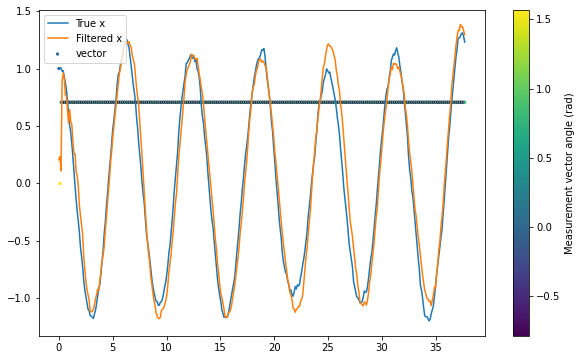

In [62]:
#run the filters
t_array, x_true, A, Q, R_val, measurement_noises, dt = generate_data()

states1, measurements_vectors = run_kalman_max_m(x_true, A, Q, R_val, measurement_noises)
#print the results for the first filter

angles = np.arctan2(measurements_vectors[:, 1], measurements_vectors[:, 0])

plt.figure(figsize=(10, 6))
plt.plot(t_array, x_true[:, 0], label='True x')
plt.plot(t_array, states1[:, 0], label='Filtered x')

# color the scatter plot
sc1 = plt.scatter(t_array, measurements_vectors[:,0], c=angles, cmap='viridis', s=5, label='vector')
plt.colorbar(sc1, label='Measurement vector angle (rad)')

plt.legend()
plt.show()


## Lorentz case

In [63]:
def run_kalman_lorenz(x_true, A, Q, R_val, dt):
    """
    Run the Kalman filter on the Lorenz system with adaptive measurement direction.

    """

    time_steps = x_true.shape[0]
    x_est = np.array([0.0, 0.0, 0.0])
    P_est = np.eye(3) * 1.0
    
    x_est_array = np.zeros((time_steps, 3))
    measurements_vector = np.zeros((time_steps, 3))

    information_gain = np.zeros(time_steps)
    EntropyRate = np.zeros(time_steps)
    
    for k in range(time_steps):
        # Predict
        Jacobian = lorenz_jacobian(x_est)
        A = scipy.linalg.expm(Jacobian*dt)

        x_pred, P_pred = kalman_predict_lorenz(x_est, P_est, A, Q, dt)
        
        # True state at step k
        xk_true = x_true[k]
        
        # Generate measurement: same noise draw, but direction is the max eigenvector
        m = select_measurement_direction_from_M(P_pred, OnlyBasis = False)
        y = m @ xk_true + np.random.normal(0, np.sqrt(R_val))
        # Update
        x_est, P_est = kalman_update_lorenz(x_pred, P_pred, y, m, R_val)
        
        diff_entropy = np.log(np.sqrt(2*np.pi*np.e*np.linalg.det(Q)))


        
        EntropyRate[k] = diff_entropy + np.log(np.abs(np.linalg.det(Jacobian)) + 1e-10)            
        #information gain
        SignalNoise = (m.T @ P_pred @ m) / R_val
        information_gain[k] = 1/2*np.log(1 + SignalNoise)    


        x_est_array[k] = x_est
        measurements_vector[k, :] = m
    
    return x_est_array, measurements_vector, information_gain, EntropyRate


## Run the Lorentz

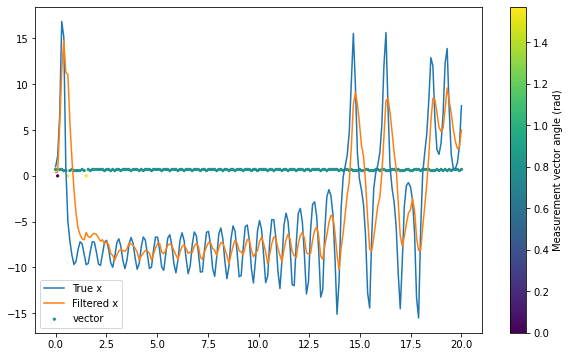

In [64]:
#Lorenz data
t_array, X_true, Y_meas = generate_lorenz_data()
A = np.eye(3)
Q = np.eye(3) * 0.01
R_val = 0.2

measurements2 = Y_meas[:,0]
states2, measurement_vectors, info, entro = run_kalman_lorenz(X_true, A, Q, R_val, dt = 0.02)

angles = np.arctan2(measurement_vectors[:, 1], measurement_vectors[:, 0])

# Plot the results for the lorentz filter
plt.figure(figsize=(10, 6))
plt.plot(t_array, X_true[:, 0], label='True x')
plt.plot(t_array, states2[:, 0], label='Filtered x')

# color the scatter plot
sc1 = plt.scatter(t_array, measurement_vectors[:,0], c=angles, cmap='viridis', s=5, label='vector')
plt.colorbar(sc1, label='Measurement vector angle (rad)')
plt.legend()
plt.show()

In [ ]:
#print the information gain and entropy rate

AverageInformationGain = np.mean(info)
AverageEntropyRate = np.mean(entro)

print(f"Average Information Gain: {AverageInformationGain}")
print(f"Average Entropy Rate: {AverageEntropyRate}")


Average Information Gain: 0.19032318500740264
Average Entropy Rate: 0.6279995690654485


'\ng)\nThe choice of measurement direction is crucial in the Kalman filter.\nThe measurement direction is osiclating in both cases.\nMuch more frequent in the one with the ociilating system.\nThe lorentz system has a more complex system and the measurement direction\nchanges less but and keeps same direction for a longer time.\n'

### f

By only using basis vectors the Average Information Gain reduced 0.01
While the Average Entropy Rate increased by 0.25

First one bing a 5% reduction and the second one
was a 50% reduction


### g

The choice of measurement direction is crucial in the Kalman filter.
The measurement direction is osiclating in both cases.
Much more frequent in the one with the ociilating system.
The lorentz system has a more complex system and the measurement direction
changes less but and keeps same direction for a longer time.
